<a href="https://colab.research.google.com/github/danicardonaibz/audio_classification/blob/main/mill_or_saw_no_mix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Deep Learning workshop sound classifier

In [ ]:
!pip3 install --upgrade matplotlib
!pip3 install tensorflow-io

In [ ]:
import os
import pathlib
import zipfile

import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.utils import plot_model

from google.colab import drive

from IPython import display

In [ ]:
# Let's check if we have GPU acceleration available
!nvidia-smi

Thu Apr 28 22:03:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Getting the data


In [ ]:
# Connect to Google Drive
DRIVE_PATH = "/content/drive"

drive.mount(DRIVE_PATH)

Mounted at /content/drive


In [ ]:
# Extract zip file containing the audio dataset
DATASET_FILE = DRIVE_PATH + "/MyDrive/dataset_v2.zip"

zipref = zipfile.ZipFile(DATASET_FILE, "r")
zipref.extractall("/content/")
zipref.close()

In [ ]:
# Get train dataset files and labels
DATASET_TRAIN_PATH = "/content/dataset_v2/train"

train_data_dir = pathlib.Path(DATASET_TRAIN_PATH)
train_labels = tf.io.gfile.listdir(train_data_dir)

print(f"Available labels: {train_labels}\n")

train_filenames = tf.io.gfile.glob(str(train_data_dir) + '/*/*') # Returns a list of files
                                                     # matching with expression
train_filenames[:5]

Available labels: ['saw', 'environment', 'mill']



['/content/dataset_v2/train/environment/environment_502.wav',
 '/content/dataset_v2/train/environment/environment_617.wav',
 '/content/dataset_v2/train/environment/environment_238.wav',
 '/content/dataset_v2/train/environment/environment_543.wav',
 '/content/dataset_v2/train/environment/environment_856.wav']

In [ ]:
# Get validation dataset files and labels
DATASET_TEST_PATH = "/content/dataset_v2/test"

test_data_dir = pathlib.Path(DATASET_TEST_PATH)
test_labels = tf.io.gfile.listdir(test_data_dir)

print(f"Available labels: {test_labels}\n")

test_filenames = tf.io.gfile.glob(str(test_data_dir) + '/*/*') # Returns a list of files
                                                     # matching with expression
test_filenames[:5]

Available labels: ['saw', 'environment', 'mill']



['/content/dataset_v2/test/saw/saw_54.wav',
 '/content/dataset_v2/test/saw/saw_269.wav',
 '/content/dataset_v2/test/saw/saw_81.wav',
 '/content/dataset_v2/test/saw/saw_174.wav',
 '/content/dataset_v2/test/saw/saw_41.wav']

In [ ]:
# Shuffling file list for training performance
train_filenames_shuffled = tf.random.shuffle(train_filenames, seed = 42)
train_filenames_shuffled[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'/content/dataset_v2/train/mill/mill_3696.wav',
       b'/content/dataset_v2/train/saw/saw_443.wav',
       b'/content/dataset_v2/train/mill/mill_3956.wav',
       b'/content/dataset_v2/train/mill/mill_2512.wav',
       b'/content/dataset_v2/train/mill/mill_2083.wav'], dtype=object)>

In [ ]:
# Getting number of samples of each label in the train dataset
num_train_samples = {}

for label in train_labels:
  num_train_samples[label] = len(tf.io.gfile.listdir(str(train_data_dir/label)))

num_train_samples

{'environment': 863, 'mill': 4633, 'saw': 1137}

In [ ]:
# Getting number of samples of each label in the test dataset
num_test_samples = {}

for label in test_labels:
  num_test_samples[label] = len(tf.io.gfile.listdir(str(test_data_dir/label)))

num_test_samples

{'environment': 216, 'mill': 1181, 'saw': 285}

In [ ]:
# Getting the total number of samples per class
num_samples = {}
for label in train_labels:
  num_samples[label] = num_train_samples[label] + num_test_samples[label]
num_samples

{'environment': 1079, 'mill': 5814, 'saw': 1422}

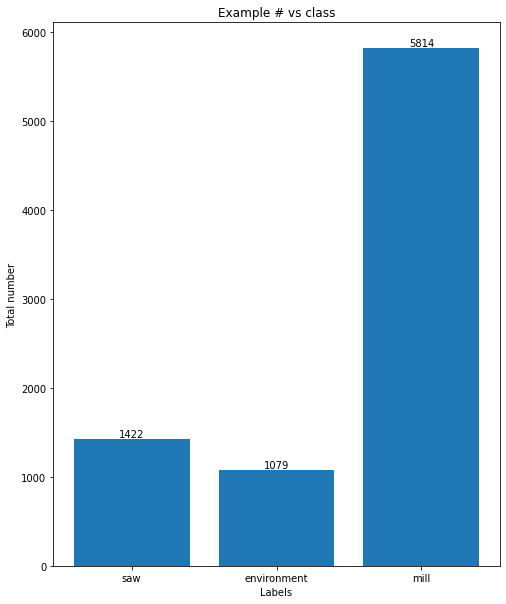

In [ ]:
# Plotting the number of samples in each label in a bar plot
fig, ax = plt.subplots(figsize = (8, 10))
bars = ax.bar(num_samples.keys(), num_samples.values())
ax.bar_label(bars)
plt.title("Example # vs class", )
plt.xlabel("Labels")
plt.ylabel("Total number")
plt.savefig("/content/class_hist.png", dpi = 600)
plt.show()

Notice the important imbalance among the labels. We have roughly **4x more examples in the mill class** with respect to the other two.

This will have an impact in the way our models learn that we'll discuss later.

### Splitting the data into train and validation sets

We'll use a 80/20 proportion.

In [ ]:
num_examples = len(train_filenames_shuffled) + len(test_filenames)

train_files = train_filenames_shuffled
test_files = test_filenames

len(train_files), len(test_files), num_examples

(6633, 1682, 8315)

In [ ]:
train_files[:2], test_files[:2]

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'/content/dataset_v2/train/mill/mill_3696.wav',
        b'/content/dataset_v2/train/saw/saw_443.wav'], dtype=object)>,
 ['/content/dataset_v2/test/saw/saw_54.wav',
  '/content/dataset_v2/test/saw/saw_269.wav'])

### Reading the waveforms
Our files use a sample rate of 44100 Hz and each file lasts for 0.5 s

In [ ]:
SAMPLE_RATE = 44100

In [ ]:
# Reading a random waveform
random_path =  random.choice(train_files)
random_file = tf.io.read_file(random_path)  # Returns a binary string of data

random_path

<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset_v2/train/mill/mill_417.wav'>

In [ ]:
# Decoding the binary string into a waveform, and playing it
test_audio, sample_rate = tf.audio.decode_wav(random_file,
                                              desired_samples = int(SAMPLE_RATE/2))
print("Audio sample: ")
display.display(display.Audio(tf.squeeze(test_audio).numpy(), rate = SAMPLE_RATE))
print("\n")
test_audio, sample_rate

Audio sample: 


(<tf.Tensor: shape=(22050, 1), dtype=float32, numpy=
 array([[0.07791138],
        [0.07260132],
        [0.06610107],
        ...,
        [0.16210938],
        [0.16000366],
        [0.14517212]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=44100>)

Now that we know how to read in files and turn them into arrays, let's
functionize the code so that we can apply it to the whole dataset.

In [ ]:
# Function to read in a .wav file and return an array
def get_waveform(audio_binary, desired_samples = int(SAMPLE_RATE/2)):
  """
  Takes in a binary string and returns an array of float32 audio components.
  """
  waveform, _ = tf.audio.decode_wav(contents = audio_binary,
                                    desired_samples = desired_samples)
  return tf.squeeze(waveform, axis = -1)  # Recovered two channels, but only one
                                          # contains information

In [ ]:
# Function to get the waveform label, given the file path
def get_label(file_path):
  """
  Takes in an audio file path and returns its label, i.e., it's parent directory
  name.
  """
  parts = tf.strings.split(
      input = file_path,
      sep = os.path.sep  # i.e. "/"
  )
  return parts[-2]  # /contents/dataset/mill/mill_0123.wav
                    # [|  -4  ||  -3  || -2 ||    -1     |]    

In [ ]:
# Bringing it all together
def get_waveform_and_label(filepath, desired_samples = int(SAMPLE_RATE)/2):
  """
  Takes in a file path and returns a tuple containing the decoded waveform and its
  class.
  """
  audio_binary = tf.io.read_file(filepath)
  waveform = get_waveform(audio_binary, desired_samples = desired_samples)
  label = get_label(filepath)
  return waveform, label

In [ ]:
# Trying out the function
random_path = random.choice(train_files)
random_waveform, label = get_waveform_and_label(filepath = random_path)

random_waveform, label

(<tf.Tensor: shape=(22050,), dtype=float32, numpy=
 array([ 0.04959106, -0.16061401, -0.00888062, ..., -0.09671021,
        -0.38388062, -0.38653564], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'saw'>)

### Building a waveform TensorFlow dataset

It will consist of tuples containing a waveform and it's assigned label

In [ ]:
# First create a file dataset, and then apply map functions to get the final
# result
files_dataset = tf.data.Dataset.from_tensor_slices(train_files)
waveform_dataset = files_dataset.map(
    map_func = get_waveform_and_label,
    num_parallel_calls = tf.data.AUTOTUNE
)

waveform_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(22050,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

#### Visualizing some random waveforms and their labels

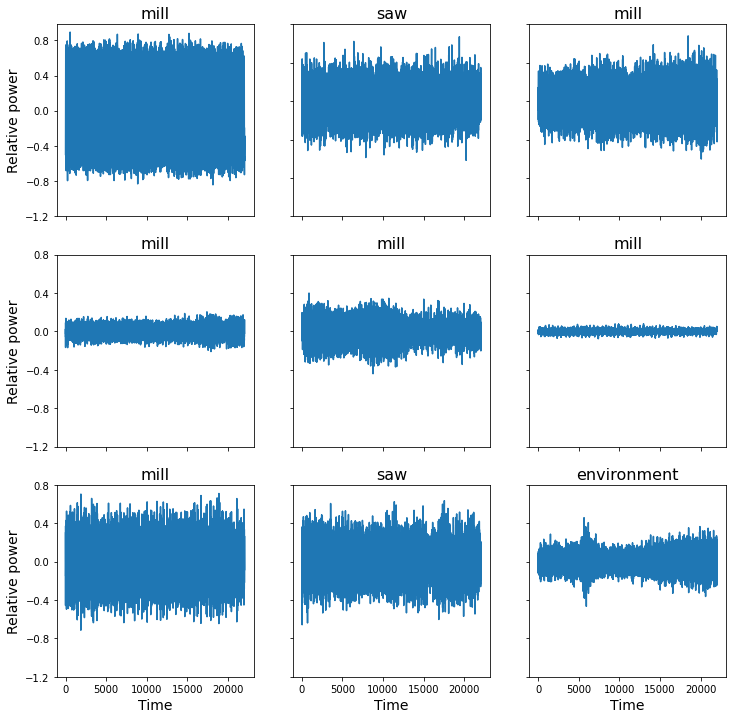

In [ ]:
num_rows = 3
num_cols = 3

n = num_rows * num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize = (12, 12))

for i, (waveform, label) in enumerate (waveform_dataset.take(n)):
  r = i // num_cols  # Returns quotient of int division
  c = i % num_cols  # Returns remainder of int division

  ax = axes[r][c]
  ax.plot(waveform.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.4))
  label = label.numpy().decode("utf-8")
  ax.set_title(label, fontsize = 16)
  ax.set_xlabel("Time", fontsize = 14)
  ax.set_ylabel("Relative power", fontsize = 14)

for ax in axes.flat:
  ax.label_outer()

plt.savefig("/content/waveform_grid.png", dpi = 600)
plt.show()

### Building a spectrogram TensorFlow dataset

Though we could theoretically start DL experiments with the data we already have, sound recognition works best when we factor in the frequency component. Introducing spectrograms.

In [ ]:
# Building a function for getting a waveform spectrogram
def get_spectrogram(waveform, frame_length = 512, frame_step = 96):
  """
  Takes in a waveform array, and returns a spectrogram represented as a tensor.
  """
  spectrogram = tfio.audio.spectrogram(
      waveform,
      nfft = frame_length,
      window = frame_length,
      stride = frame_step)
  return tf.expand_dims(spectrogram, axis = -1)  # Return the right shape for
                                                 # using a CNN  

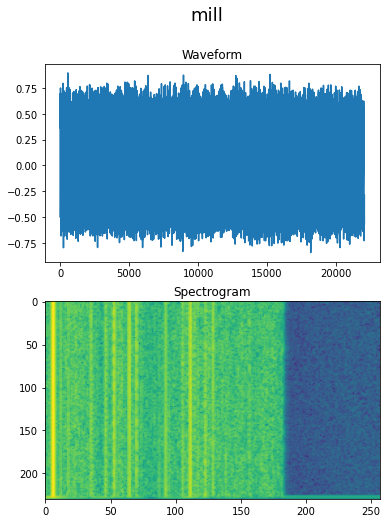

In [ ]:
# Plotting a waveform along it's spectrogram
fig, axes = plt.subplots(2, figsize = (6, 8))

for waveform, label in waveform_dataset.take(1):
  spectrogram = get_spectrogram(waveform)
  axes[0].plot(waveform)
  axes[0].set_title("Waveform")
  axes[1].imshow(tf.math.log(spectrogram).numpy(), aspect = 'auto')
  axes[1].set_title("Spectrogram")
plt.suptitle(label.numpy().decode("utf-8"), fontsize = 18)
plt.show()

Now we're going to turn our waveform dataset into a spectrogram dataset. We will be
replacing the labels for their integer matching value as well.

In [ ]:
# Building the function
def get_spectrogram_and_label_id(waveform, label,
                                 frame_length = 512, frame_step = 96):
  """
  Takes in a tuple of a waveform and a label, and returns a tuple of a spectrogram
  and label_id.
  """
  spectrogram = get_spectrogram(waveform, frame_length = frame_length,
                                frame_step = frame_step)
  label_id = tf.argmax(label == train_labels)  # Get label index
  
  return spectrogram, label_id

In [ ]:
# Aplying the function to the waveform dataset
spectrogram_dataset = waveform_dataset.map(
    map_func = get_spectrogram_and_label_id,
    num_parallel_calls = tf.data.AUTOTUNE
)

#### Visualizing some random spectrograms and their labels

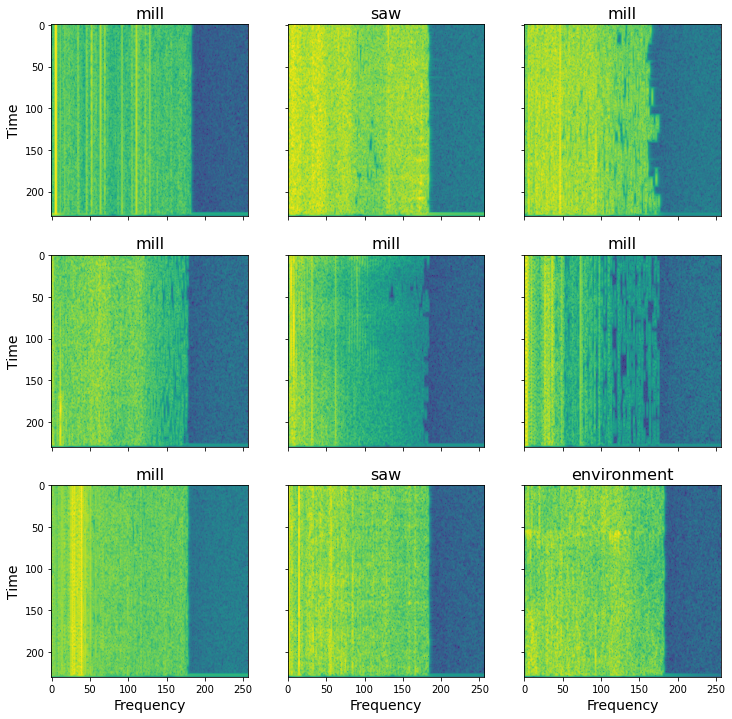

In [ ]:
# Plotting an array of spectrograms with their labels
num_rows = 3
num_cols = 3

n = num_rows*num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize = (12, 12))

for i, (spectrogram, label_id) in enumerate(spectrogram_dataset.take(n)):
  r = i // num_cols
  c = i % num_cols

  ax = axes [r][c]
  ax.set_title(train_labels[label_id.numpy()], fontsize = 16)
  ax.imshow(tf.math.log(spectrogram).numpy(), aspect = 'auto')
  ax.set_xlabel("Frequency", fontsize = 14)
  ax.set_ylabel("Time", fontsize = 14)

for ax in axes.flat:
  ax.label_outer()

plt.savefig("/content/spectrogram_grid.png", dpi = 600)
plt.show()

### Preparing the dataset for Deep Learning experiments
The following steps have the aim to create a fast pipeline to input the data into the models.

In [ ]:
# Let's bring a function to perform all the steps needed for getting a spectrogram given a .wav file path
def preprocess_data(files):
  """
  Takes in a path TensorFlow dataset and returns a dataset of spectrograms and
  their corresponding labels.
  """
  files_dataset = tf.data.Dataset.from_tensor_slices(files)
  output_dataset = files_dataset.map(
      map_func = get_waveform_and_label,
      num_parallel_calls = tf.data.AUTOTUNE)
  output_dataset = output_dataset.map(
      map_func = get_spectrogram_and_label_id,
      num_parallel_calls = tf.data.AUTOTUNE)
  return output_dataset

In [ ]:
# Building training and validation dataset
BATCH_SIZE = 64
train_dataset = preprocess_data(train_files).cache().shuffle(6636).batch(BATCH_SIZE)
validation_dataset = preprocess_data(test_files).cache().batch(BATCH_SIZE)
train_dataset, validation_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None, 230, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 230, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
len(train_files), len(test_files)

(6633, 1682)

In [ ]:
# Caching and prefetching
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Get some insights form the input data before starting with our experiments
for spectrogram, _ in train_dataset.unbatch().take(1):
  input_shape = spectrogram.shape
  print(f"Input shape is: {input_shape}.")

Input shape is: (230, 257, 1).


## DL models
We will first set a baseline: a simple and easy to train model. The goal will then to build more complex models which hopefully will outperform the baseline.

But before starting with the experimentation, we will normalize the inputs with a normalization layer.

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
# tf.config.run_functions_eagerly(True) for debugging purposes, because graph mode has poor traceback.

In [ ]:
# Instantiating a normalization layer
norm_layer = tf.keras.layers.Normalization(name = "normalization_layer")

norm_layer.adapt(data = train_dataset.map(
    map_func = lambda spectrogram, label: spectrogram,  # Only passes the spectrogram
    num_parallel_calls = tf.data.AUTOTUNE
))  # Computes the mean and variance of the spectrograms in the dataset,
    # to standardize the data fed to the neural network.

In [ ]:
# Getting the ground-truth validation labels
y_true = []
for _, element in validation_dataset.unbatch():
  y_true.append(element.numpy())

y_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Model 0: Baseline
The first model won't take into consideration the imbalance among the three classes.
It will consist of two dense layers with non-linear activation and an output layer.

In [ ]:
# Building model 0
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = norm_layer(inputs)
x = tf.keras.layers.Flatten(name = "flatten_layer")(x)
x = tf.keras.layers.Dense(units = 10, activation = "relu")(x)
output = tf.keras.layers.Dense(units = 3,
                               activation = "softmax",
                               name = "output_layer")(x)

model_0 = tf.keras.Model(inputs = inputs,
                         outputs = output,
                         name = "model_0_baseline")

In [ ]:
# Compiling the model
model_0.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_0.summary(show_trainable = True)

Model: "model_0_baseline"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_layer (InputLayer)    [(None, 230, 257, 1)]     0         Y          
                                                                            
 normalization_layer (Normal  (None, 230, 257, 1)      3         Y          
 ization)                                                                   
                                                                            
 flatten_layer (Flatten)     (None, 59110)             0         Y          
                                                                            
 dense (Dense)               (None, 10)                591110    Y          
                                                                            
 output_layer (Dense)        (None, 3)                 33        Y          
                                                  

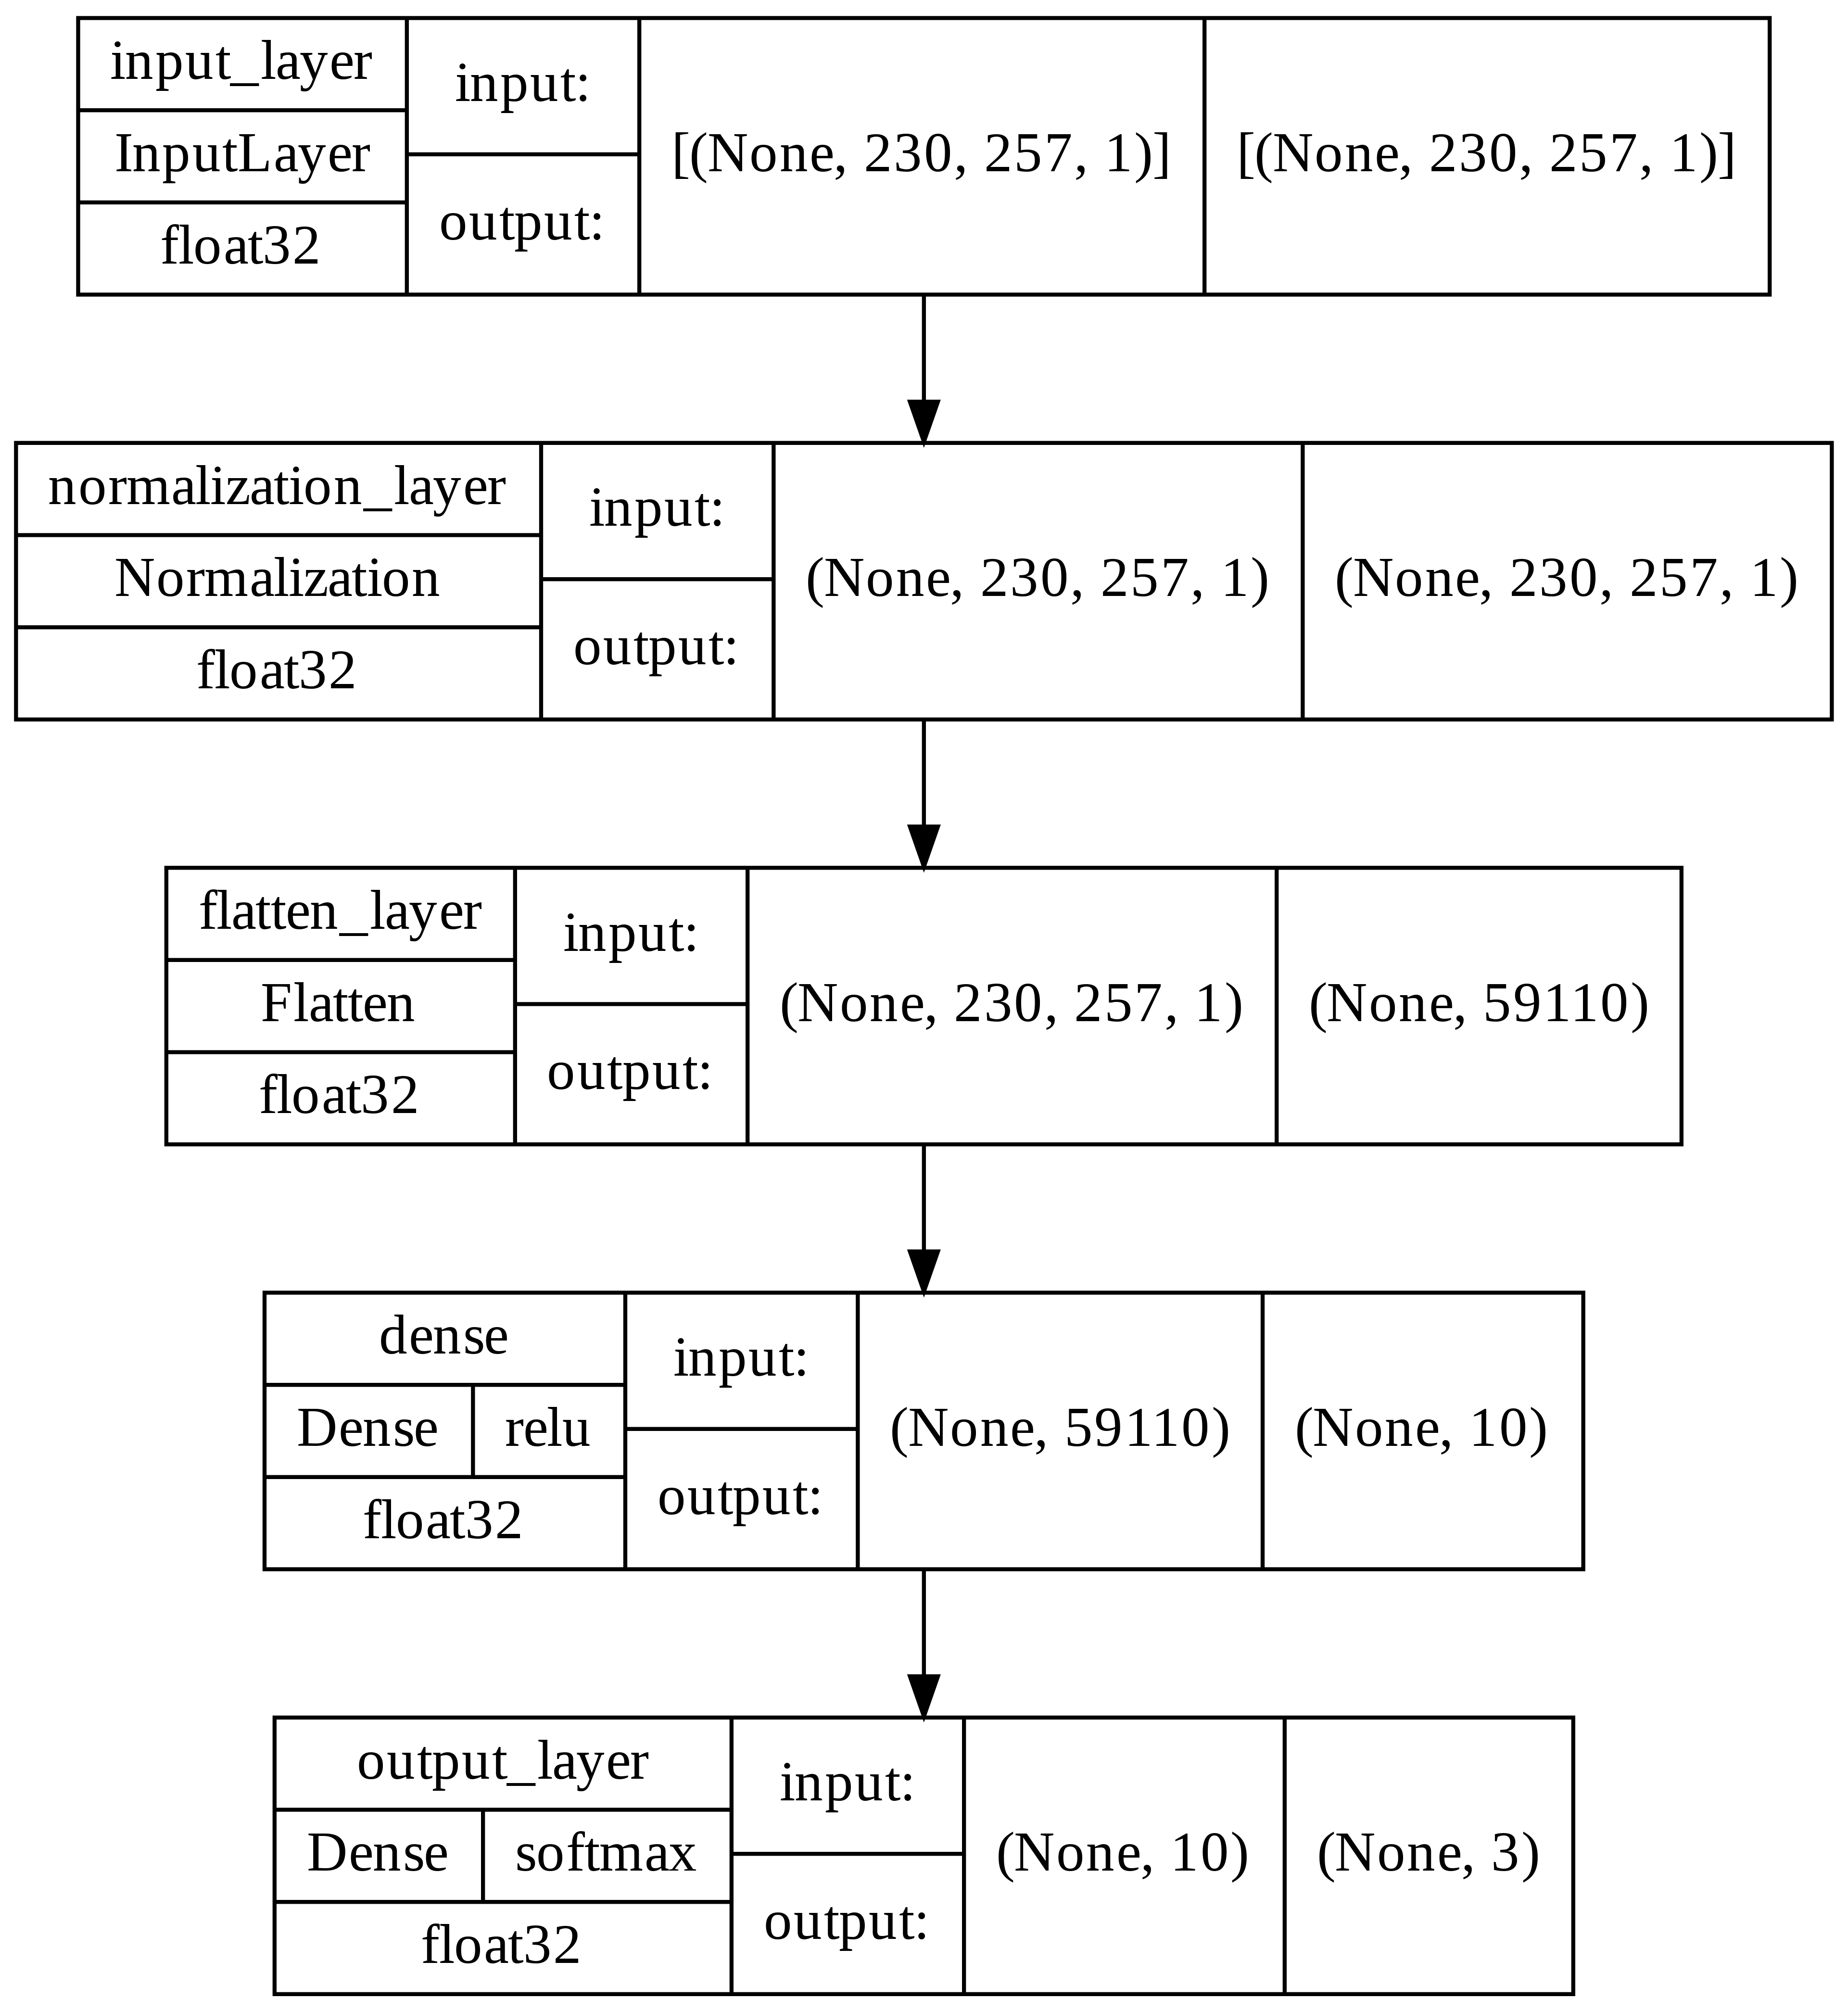

In [ ]:
# Plot model 0
plot_model(model_0,
           show_shapes = True,
           show_dtype = True,
           dpi = 600,
           show_layer_activations = True
           )

In [ ]:
# Fitting model 0
model_0.fit(train_dataset,
            epochs = 100,
            validation_data = validation_dataset,
            callbacks = [
                         tf.keras.callbacks.EarlyStopping(
                             patience = 20,
                             monitor = "val_loss",
                             restore_best_weights = True
                         ),
                         tf.keras.callbacks.ReduceLROnPlateau(
                             patience = 10,
                             monitor = "val_loss",
                             verbose = 1
                         )
            ])

Epoch 1/100
104/104 [==============================] - 5s 14ms/step - loss: 0.9578 - accuracy: 0.7487 - val_loss: 1.2970 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - 1s 12ms/step - loss: 0.4069 - accuracy: 0.7802 - val_loss: 1.1668 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 3/100
104/104 [==============================] - 1s 12ms/step - loss: 0.3764 - accuracy: 0.8173 - val_loss: 1.8147 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 4/100
104/104 [==============================] - 1s 11ms/step - loss: 0.3701 - accuracy: 0.8417 - val_loss: 1.6933 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 5/100
104/104 [==============================] - 1s 12ms/step - loss: 0.3252 - accuracy: 0.8530 - val_loss: 1.8055 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 6/100
104/104 [==============================] - 1s 12ms/step - loss: 0.3097 - accuracy: 0.8613 - val_loss: 1.9097 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 7/100
104/104 [==============================] - 1s 

In [ ]:
model_0.evaluate(validation_dataset)

27/27 [==============================] - 0s 9ms/step - loss: 1.1668 - accuracy: 0.7973


[1.1668192148208618, 0.7972651720046997]

In [ ]:
# Making predictions with model 0
model_0_probs = model_0.predict(validation_dataset)
model_0_probs[:5]

array([[0.33677083, 0.318832  , 0.3443972 ],
       [1.        , 0.        , 0.        ],
       [0.33677083, 0.318832  , 0.3443972 ],
       [0.00699023, 0.3137027 , 0.67930704],
       [1.        , 0.        , 0.        ]], dtype=float32)

In [ ]:
# Getting probabilities
model_0_preds = tf.argmax(model_0_probs, axis = 1)
model_0_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([2, 0, 2, 2, 0])>

In [ ]:
model_0_results = classification_report(y_true = y_true,
                                        y_pred = model_0_preds,
                                        target_names = train_labels,
                                        output_dict = True)
model_0_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.7972651605231866,
 'environment': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 216},
 'macro avg': {'f1-score': 0.5309816669230055,
  'precision': 0.5919842312746386,
  'recall': 0.52046783625731,
  'support': 1682},
 'mill': {'f1-score': 0.8738438771735109,
  'precision': 0.7759526938239159,
  'recall': 1.0,
  'support': 1181},
 'saw': {'f1-score': 0.7191011235955056,
  'precision': 1.0,
  'recall': 0.5614035087719298,
  'support': 285},
 'weighted avg': {'f1-score': 0.7354063253071554,
  'precision': 0.7142688058299909,
  'recall': 0.7972651605231866,
  'support': 1682}}

In [ ]:
# Saving the model
model_0.save("model_0")

INFO:tensorflow:Assets written to: model_0/assets


### Model 1: Taking into account class imbalance
This model will have the same structure but will weight each class according with the number of samples we have.

In [ ]:
num_samples, num_examples, train_labels, test_labels

({'environment': 1079, 'mill': 5814, 'saw': 1422},
 8315,
 ['saw', 'environment', 'mill'],
 ['saw', 'environment', 'mill'])

In [ ]:
# Dictionary with target class weights
class_weights = {}
for i, label in enumerate(train_labels):
  class_weights[i] = (1 / num_samples[label]) * (num_examples / 3) 
class_weights

{0: 1.9491326769807782, 1: 2.568736484399135, 2: 0.4767228528838436}

In [ ]:
# Building model 2
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = norm_layer(inputs)
x = tf.keras.layers.Flatten(name = "flatten_layer")(x)
x = tf.keras.layers.Dense(units = 10, activation = "relu")(x)
outputs = tf.keras.layers.Dense(units = 3,
                                activation = "softmax",
                                name = "output_layer")(x)

model_1 = tf.keras.Model(inputs = inputs,
                          outputs = outputs,
                          name = "model_1")

In [ ]:
# Compiling model 2
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fitting model 2
model_1.fit(train_dataset,
            epochs = 100,
            validation_data = validation_dataset,
            callbacks = [
                         tf.keras.callbacks.EarlyStopping(
                             patience = 20,
                             monitor = "val_loss",
                             restore_best_weights = True
                         ),
                         tf.keras.callbacks.ReduceLROnPlateau(
                             patience = 10,
                             monitor = "val_loss",
                             verbose = 1
                         )
            ],
            class_weight = class_weights)

Epoch 1/100
104/104 [==============================] - 2s 13ms/step - loss: 0.9787 - accuracy: 0.6953 - val_loss: 1.0085 - val_accuracy: 0.5892 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - 1s 12ms/step - loss: 0.4705 - accuracy: 0.7398 - val_loss: 1.6398 - val_accuracy: 0.5321 - lr: 0.0010
Epoch 3/100
104/104 [==============================] - 1s 12ms/step - loss: 0.4347 - accuracy: 0.7051 - val_loss: 1.3302 - val_accuracy: 0.5196 - lr: 0.0010
Epoch 4/100
104/104 [==============================] - 1s 12ms/step - loss: 0.3077 - accuracy: 0.8057 - val_loss: 1.1374 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 5/100
104/104 [==============================] - 1s 12ms/step - loss: 0.2780 - accuracy: 0.8143 - val_loss: 1.3035 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 6/100
104/104 [==============================] - 1s 12ms/step - loss: 0.2386 - accuracy: 0.8768 - val_loss: 1.1526 - val_accuracy: 0.6623 - lr: 0.0010
Epoch 7/100
104/104 [==============================] - 1s 

In [ ]:
model_1.evaluate(validation_dataset)

27/27 [==============================] - 0s 10ms/step - loss: 1.0085 - accuracy: 0.5892


[1.008479356765747, 0.5891795754432678]

In [ ]:
# Getting model 1 predictions
model_1_probs = model_1.predict(validation_dataset)
model_1_preds = tf.argmax(model_1_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(1682,), dtype=int64, numpy=array([0, 0, 0, ..., 2, 1, 2])>

In [ ]:
# Get summary report
model_1_results = classification_report(
    y_true = y_true,
    y_pred = model_1_preds,
    target_names = train_labels,
    output_dict = True
)
model_1_results

{'accuracy': 0.5891795481569561,
 'environment': {'f1-score': 0.30103092783505153,
  'precision': 0.19363395225464192,
  'recall': 0.6759259259259259,
  'support': 216},
 'macro avg': {'f1-score': 0.5956575080144396,
  'precision': 0.6896554671238996,
  'recall': 0.6359518177951857,
  'support': 1682},
 'mill': {'f1-score': 0.6809623430962343,
  'precision': 0.8905608755129959,
  'recall': 0.5512277730736664,
  'support': 1181},
 'saw': {'f1-score': 0.8049792531120332,
  'precision': 0.9847715736040609,
  'recall': 0.6807017543859649,
  'support': 285},
 'weighted avg': {'f1-score': 0.6531856686955727,
  'precision': 0.8170256992538694,
  'recall': 0.5891795481569561,
  'support': 1682}}

In [ ]:
# Save model
model_1.save("model_1")

INFO:tensorflow:Assets written to: model_1/assets


### Model 2: Increasing model's complexity by adding another dense layer

In [ ]:
# Building model 2
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = norm_layer(inputs)
x = tf.keras.layers.Flatten(name = "flatten_layer")(x)
x = tf.keras.layers.Dense(units = 10, activation = "relu")(x)
x = tf.keras.layers.Dense(units = 10, activation = "relu")(x)
outputs = tf.keras.layers.Dense(units = 3,
                                activation = "softmax",
                                name = "output_layer")(x)

model_2 = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_2")

model_2.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 230, 257, 1)]     0         
                                                                 
 normalization_layer (Normal  (None, 230, 257, 1)      3         
 ization)                                                        
                                                                 
 flatten_layer (Flatten)     (None, 59110)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                591110    
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 output_layer (Dense)        (None, 3)                 33        
                                                           

In [ ]:
# Compiling model 2
model_2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fitting model 2
model_2.fit(train_dataset,
            epochs = 100,
            validation_data = validation_dataset,
            callbacks = [
                         tf.keras.callbacks.EarlyStopping(
                             patience = 20,
                             monitor = "val_loss",
                             restore_best_weights = True
                         ),
                         tf.keras.callbacks.ReduceLROnPlateau(
                             patience = 10,
                             monitor = "val_loss",
                             verbose = 1
                         )
            ],
            class_weight = class_weights)

Epoch 1/100
104/104 [==============================] - 2s 14ms/step - loss: 0.9182 - accuracy: 0.6709 - val_loss: 0.9768 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - 1s 12ms/step - loss: 0.5376 - accuracy: 0.8289 - val_loss: 0.8439 - val_accuracy: 0.6688 - lr: 0.0010
Epoch 3/100
104/104 [==============================] - 1s 12ms/step - loss: 0.4955 - accuracy: 0.8351 - val_loss: 0.7508 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 4/100
104/104 [==============================] - 1s 12ms/step - loss: 0.4263 - accuracy: 0.8526 - val_loss: 1.3199 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 5/100
104/104 [==============================] - 1s 13ms/step - loss: 0.4265 - accuracy: 0.8455 - val_loss: 1.4200 - val_accuracy: 0.6724 - lr: 0.0010
Epoch 6/100
104/104 [==============================] - 1s 13ms/step - loss: 0.3714 - accuracy: 0.8690 - val_loss: 1.4001 - val_accuracy: 0.6772 - lr: 0.0010
Epoch 7/100
104/104 [==============================] - 1s 

In [ ]:
# Evaluating model 2
model_2.evaluate(validation_dataset)

27/27 [==============================] - 0s 9ms/step - loss: 0.7508 - accuracy: 0.7883


[0.7508201599121094, 0.7883471846580505]

In [ ]:
# Making predictions with model 2
model_2_probs = model_2.predict(validation_dataset)
model_2_preds = tf.argmax(model_2_probs, axis = 1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 1, 0])>

In [ ]:
model_2_results = classification_report(
    y_true = y_true,
    y_pred = model_2_preds,
    output_dict = True,
    target_names = train_labels
)
model_2_results

{'accuracy': 0.7883472057074911,
 'environment': {'f1-score': 0.4007561436672968,
  'precision': 0.33865814696485624,
  'recall': 0.49074074074074076,
  'support': 216},
 'macro avg': {'f1-score': 0.6907756163669352,
  'precision': 0.7359286241815464,
  'recall': 0.6765165532453142,
  'support': 1682},
 'mill': {'f1-score': 0.8732513777024163,
  'precision': 0.8743633276740238,
  'recall': 0.8721422523285352,
  'support': 1181},
 'saw': {'f1-score': 0.7983193277310924,
  'precision': 0.9947643979057592,
  'recall': 0.6666666666666666,
  'support': 285},
 'weighted avg': {'f1-score': 0.7998776530927771,
  'precision': 0.825969740267879,
  'recall': 0.7883472057074911,
  'support': 1682}}

In [ ]:
# Saving model
model_2.save("model_2")

INFO:tensorflow:Assets written to: model_2/assets


### Model 3: Introducing CNNs
We'll use a combination of Conv2D layers and MaxPool layers.

In [ ]:
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = norm_layer(inputs)
x = tf.keras.layers.Resizing(128, 128)(x)
x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = 3,
                           activation = "relu",
                           name = "convolutional_layer")(x)
x = tf.keras.layers.MaxPool2D(name = "max_pool_layer")(x)
x = tf.keras.layers.Dropout(0.25, name = "first_dropout")(x)
x = tf.keras.layers.Flatten(name = "flatten_layer")(x)
x = tf.keras.layers.Dense(units = 128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5, name = "second_dropout")(x)
outputs = tf.keras.layers.Dense(units = 3,
                          activation = "softmax",
                          name = "output_layer")(x)

model_3 = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_3")

In [ ]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 230, 257, 1)]     0         
                                                                 
 normalization_layer (Normal  (None, 230, 257, 1)      3         
 ization)                                                        
                                                                 
 resizing (Resizing)         (None, 128, 128, 1)       0         
                                                                 
 convolutional_layer (Conv2D  (None, 126, 126, 64)     640       
 )                                                               
                                                                 
 max_pool_layer (MaxPooling2  (None, 63, 63, 64)       0         
 D)                                                              
                                                           

In [ ]:
# Compiling model 3
model_3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fitting model 3
model_3.fit(train_dataset,
            epochs = 100,
            validation_data = validation_dataset,
            callbacks = [
                         tf.keras.callbacks.EarlyStopping(
                             patience = 10,
                             monitor = "val_loss",
                             restore_best_weights = True
                         ),
                         tf.keras.callbacks.ReduceLROnPlateau(
                             patience = 5,
                             monitor = "val_loss",
                             verbose = 1
                         )
            ],
            class_weight = class_weights)

Epoch 1/100
104/104 [==============================] - 11s 36ms/step - loss: 1.2511 - accuracy: 0.7466 - val_loss: 0.7303 - val_accuracy: 0.7015 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - 3s 32ms/step - loss: 0.2998 - accuracy: 0.8441 - val_loss: 0.6891 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 3/100
104/104 [==============================] - 3s 32ms/step - loss: 0.2344 - accuracy: 0.8854 - val_loss: 0.5479 - val_accuracy: 0.8074 - lr: 0.0010
Epoch 4/100
104/104 [==============================] - 3s 31ms/step - loss: 0.1972 - accuracy: 0.9092 - val_loss: 0.6982 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 5/100
104/104 [==============================] - 3s 31ms/step - loss: 0.1987 - accuracy: 0.9034 - val_loss: 0.8875 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 6/100
104/104 [==============================] - 3s 31ms/step - loss: 0.1587 - accuracy: 0.9237 - val_loss: 0.5781 - val_accuracy: 0.8335 - lr: 0.0010
Epoch 7/100
104/104 [==============================] - 3s

In [ ]:
# Evaluating model 3
model_3.evaluate(validation_dataset)

27/27 [==============================] - 0s 14ms/step - loss: 0.5479 - accuracy: 0.8074


[0.5478727221488953, 0.8073721528053284]

In [ ]:
# Making some predictions with model 3
model_3_probs = model_3.predict(validation_dataset)
model_3_preds = tf.argmax(model_3_probs, axis = 1)
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 1, 0])>

In [ ]:
# Getting model 3 results
model_3_results = classification_report(
    y_true = y_true,
    y_pred = model_3_preds,
    output_dict = True,
    target_names = train_labels
)
model_3_results

{'accuracy': 0.807372175980975,
 'environment': {'f1-score': 0.5543964232488824,
  'precision': 0.4087912087912088,
  'recall': 0.8611111111111112,
  'support': 216},
 'macro avg': {'f1-score': 0.758919425588607,
  'precision': 0.7682129469706682,
  'recall': 0.813045821346102,
  'support': 1682},
 'mill': {'f1-score': 0.8762080073630926,
  'precision': 0.9596774193548387,
  'recall': 0.8060965283657917,
  'support': 1181},
 'saw': {'f1-score': 0.8461538461538461,
  'precision': 0.9361702127659575,
  'recall': 0.7719298245614035,
  'support': 285},
 'weighted avg': {'f1-score': 0.829789019186336,
  'precision': 0.8849503234216787,
  'recall': 0.807372175980975,
  'support': 1682}}

In [ ]:
# Saving model
model_3.save("model_3")

INFO:tensorflow:Assets written to: model_3/assets


### Model 4: Increasing CNN model's complexity

In [ ]:
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = norm_layer(inputs)
x = tf.keras.layers.Resizing(128, 128)(x)
x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = 3,
                           activation = "relu")(x)
x = tf.keras.layers.Conv2D(filters = 128,
                           kernel_size = 3,
                           activation = "relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(units = 3,
                          activation = "softmax",
                          name = "output_layer")(x)

model_4 = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_4")

In [ ]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 230, 257, 1)]     0         
                                                                 
 normalization_layer (Normal  (None, 230, 257, 1)      3         
 ization)                                                        
                                                                 
 resizing_1 (Resizing)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 128)      0         
 )                                                         

In [ ]:
# Compiling model 4
model_4.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fitting model 4
model_4.fit(train_dataset,
            epochs = 100,
            validation_data = validation_dataset,
            callbacks = [
                         tf.keras.callbacks.EarlyStopping(
                             monitor = "val_loss",
                             patience = 10,
                             restore_best_weights = True
                         ),
                         tf.keras.callbacks.ReduceLROnPlateau(
                             monitor = "val_loss",
                             patience = 5,
                             verbose = 1
                         )
            ],
            class_weight = class_weights)

Epoch 1/100
104/104 [==============================] - 13s 120ms/step - loss: 0.8505 - accuracy: 0.7635 - val_loss: 0.7913 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - 11s 104ms/step - loss: 0.2263 - accuracy: 0.8933 - val_loss: 0.5639 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 3/100
104/104 [==============================] - 11s 102ms/step - loss: 0.1509 - accuracy: 0.9317 - val_loss: 0.5867 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 4/100
104/104 [==============================] - 11s 102ms/step - loss: 0.0970 - accuracy: 0.9549 - val_loss: 0.7316 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 5/100
104/104 [==============================] - 11s 102ms/step - loss: 0.0701 - accuracy: 0.9682 - val_loss: 0.7017 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 6/100
104/104 [==============================] - 11s 102ms/step - loss: 0.0633 - accuracy: 0.9701 - val_loss: 0.7235 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 7/100
104/104 [=========================

In [ ]:
model_4.evaluate(validation_dataset)

27/27 [==============================] - 1s 33ms/step - loss: 0.5639 - accuracy: 0.7889


[0.5638759732246399, 0.7889417409896851]

In [ ]:
# Making predictions with model 4
model_4_probs = model_4.predict(validation_dataset)
model_4_preds = tf.argmax(model_4_probs, axis = 1)
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 1, 0])>

In [ ]:
# Get summary report
model_4_results = classification_report(
    y_true = y_true,
    y_pred = model_4_preds,
    output_dict = True,
    target_names = train_labels
)
model_4_results

{'accuracy': 0.7889417360285375,
 'environment': {'f1-score': 0.5160349854227405,
  'precision': 0.37659574468085105,
  'recall': 0.8194444444444444,
  'support': 216},
 'macro avg': {'f1-score': 0.7428988712709739,
  'precision': 0.7560311276378978,
  'recall': 0.7947221933373276,
  'support': 1682},
 'mill': {'f1-score': 0.8604543347241538,
  'precision': 0.9508196721311475,
  'recall': 0.785774767146486,
  'support': 1181},
 'saw': {'f1-score': 0.852207293666027,
  'precision': 0.940677966101695,
  'recall': 0.7789473684210526,
  'support': 285},
 'weighted avg': {'f1-score': 0.8148271134692957,
  'precision': 0.8753602461218383,
  'recall': 0.7889417360285375,
  'support': 1682}}

In [ ]:
# Saving model
model_4.save("model_4")

INFO:tensorflow:Assets written to: model_4/assets


### Model 5: Changing topology of the CNN

In [ ]:
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = norm_layer(inputs)
x = tf.keras.layers.Resizing(128, 128)(x)
x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = 5,
                           activation = "relu")(x)
x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = 3,
                           activation = "relu")(x)
x = tf.keras.layers.Conv2D(filters = 128,
                           kernel_size = 3,
                           activation = "relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(units = 3,
                          activation = "softmax",
                          name = "output_layer")(x)

model_5 = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_5")

In [ ]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 230, 257, 1)]     0         
                                                                 
 normalization_layer (Normal  (None, 230, 257, 1)      3         
 ization)                                                        
                                                                 
 resizing_2 (Resizing)       (None, 128, 128, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      1664      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 128)     73856     
                                                           

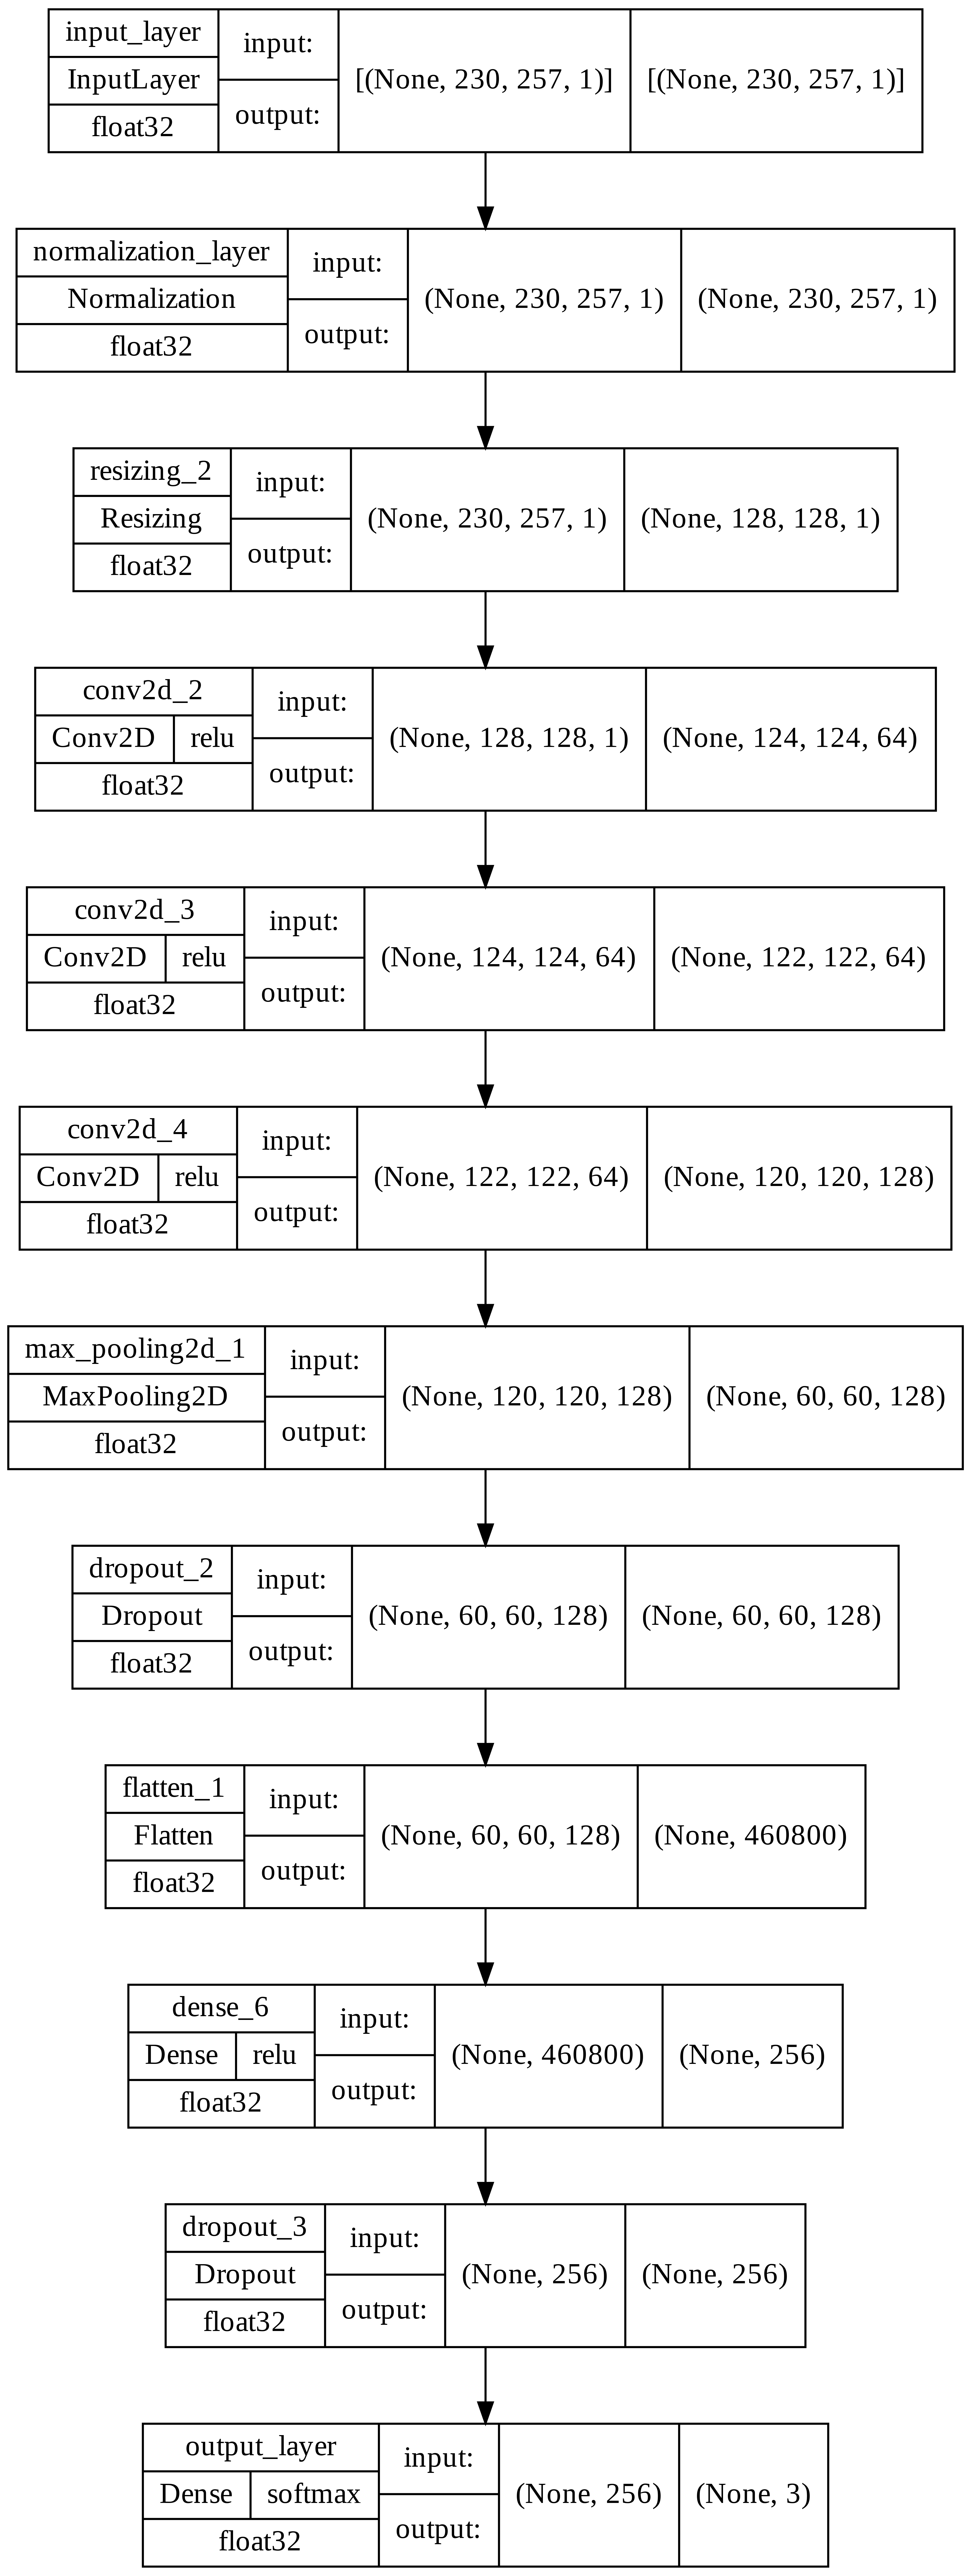

In [ ]:
# Plot model 5
plot_model(model_5,
           to_file="model_5_cnn_extra_maxpool.png",
           show_shapes = True,
           show_dtype = True,
           dpi = 600,
           show_layer_activations = True
           )

In [ ]:
# Compiling model 5
model_5.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fitting model 5
model_5.fit(train_dataset,
            epochs = 100,
            validation_data = validation_dataset,
            callbacks = [
                         tf.keras.callbacks.EarlyStopping(
                             monitor = "val_loss",
                             patience = 10,
                             restore_best_weights = True
                         ),
                         tf.keras.callbacks.ReduceLROnPlateau(
                             monitor = "val_loss",
                             patience = 5,
                             verbose = 1
                         )
            ],
            class_weight = class_weights)

Epoch 1/100
104/104 [==============================] - 15s 136ms/step - loss: 0.8800 - accuracy: 0.7277 - val_loss: 0.6661 - val_accuracy: 0.7235 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - 13s 124ms/step - loss: 0.2812 - accuracy: 0.8690 - val_loss: 0.7568 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 3/100
104/104 [==============================] - 13s 124ms/step - loss: 0.1793 - accuracy: 0.9209 - val_loss: 0.9025 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 4/100
104/104 [==============================] - 13s 124ms/step - loss: 0.1232 - accuracy: 0.9436 - val_loss: 1.0834 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 5/100
104/104 [==============================] - 13s 124ms/step - loss: 0.0818 - accuracy: 0.9643 - val_loss: 0.8570 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 6/100
104/104 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9686
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
104/104 [======================

In [ ]:
model_5.evaluate(validation_dataset)

27/27 [==============================] - 1s 40ms/step - loss: 0.6661 - accuracy: 0.7235


[0.6661414504051208, 0.7235434055328369]

In [ ]:
# Making predictions on model 5
model_5_probs = model_5.predict(validation_dataset)
model_5_preds = tf.argmax(model_5_probs, axis = 1)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 1, 0])>

In [ ]:
# Getting model 5 results
model_5_results = classification_report(
    y_true = y_true,
    y_pred = model_5_preds,
    output_dict = True,
    target_names = train_labels
)
model_5_results

{'accuracy': 0.7235434007134364,
 'environment': {'f1-score': 0.4755614266842801,
  'precision': 0.33271719038817005,
  'recall': 0.8333333333333334,
  'support': 216},
 'macro avg': {'f1-score': 0.6801043768921634,
  'precision': 0.6878691376051839,
  'recall': 0.756809820203911,
  'support': 1682},
 'mill': {'f1-score': 0.8052580331061343,
  'precision': 0.9473081328751431,
  'recall': 0.7002540220152413,
  'support': 1181},
 'saw': {'f1-score': 0.7594936708860759,
  'precision': 0.7835820895522388,
  'recall': 0.7368421052631579,
  'support': 285},
 'weighted avg': {'f1-score': 0.7551645074106308,
  'precision': 0.8406413279261455,
  'recall': 0.7235434007134364,
  'support': 1682}}

In [ ]:
# Save model
model_5.save("model_5")

INFO:tensorflow:Assets written to: model_5/assets


### Model 6: Adding data augmentation
The main goal of data augmentation is to artificially increment data variability to prevent overfitting and to help the model generalize better.

#### Spectrogram data augmentation
Spectrogram augmentation has nothing to do with regular image data augmentation, say, random rotation, flip, zoom or crop, etc. This is because performing such kind of operations to a spectrogram would render the waveform it represents completely unrecognizable. Thus, audio recognition practitioning has a special type of data augmentation based on **masking out time and frequency chunks**, which we'll see right now.

In [ ]:
for spectrogram, label in train_dataset.unbatch().take(1):
  test_spectrogram = spectrogram[:, :, 0].numpy()
  label = label.numpy()

We will be using `tfio.mask_freq` and `tfio.mask_time` functions to perform data augmentation **only to the training data**.

In [ ]:
# Get augmented spectrograms
freq_augmented_spectrogram = tfio.audio.freq_mask(test_spectrogram, param = 60)
time_augmented_spectrogram = tfio.audio.time_mask(test_spectrogram, param = 60)
freq_time_augmented_spectrogram = tfio.audio.time_mask(freq_augmented_spectrogram,
                                                     param = 30)
spectrograms = [[test_spectrogram, "Original"],
                [freq_augmented_spectrogram,"Frequency Agumentation"],
                [time_augmented_spectrogram, "Time Augmentation"],
                [freq_time_augmented_spectrogram, "Time and Frequency Augmentation"]]

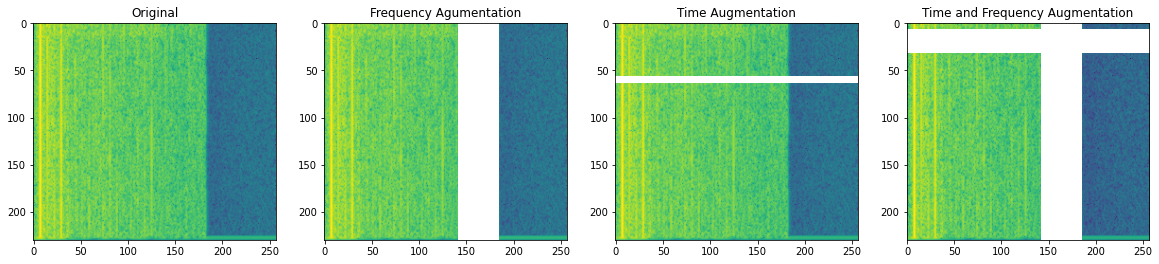

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(20, 10))
for i, ax in enumerate(axes):
  ax.imshow(tf.math.log(spectrograms[i][0]).numpy())
  ax.set_title(f"{spectrograms[i][1]}")

Now that's clear how these functions work, let's embed them ito a keras custom layer to augment our spectrograms on the fly.

In [ ]:
# Embedding our functions into a layer to provide data augmentation on the fly
class FreqTimeAugment(tf.keras.layers.Layer):
  def __init__(self,
               mask_freq = True,
               mask_freq_width = 30,
               mask_time = True,
               mask_time_width = 30,
               **kwargs):
    super().__init__(**kwargs)
    self.mask_freq = mask_freq
    self.mask_time = mask_time
    self.mask_freq_width = mask_freq_width
    self.mask_time_width = mask_time_width

    self.freq_mask = lambda x: tf.expand_dims(tfio.audio.freq_mask(x[:, :, 0], param = mask_freq), axis = -1)
    self.time_mask = lambda x: tf.expand_dims(tfio.audio.time_mask(x[:, :, 0], param = mask_time), axis = -1)

  def build(self, input_shape):
    print(f"input_shape to augment layer is {input_shape}")
  
  @tf.function
  def call(self, inputs, training = None):
    if training:
      if self.mask_freq:
        inputs = tf.map_fn(self.freq_mask, elems = inputs)
      if self.mask_time:
        inputs = tf.map_fn(self.time_mask, elems = inputs)
      return inputs
    else:
      return inputs

Now let's build the CNN model with data augmentation.

In [ ]:
# Build the model
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = FreqTimeAugment(mask_freq = True,
                    mask_freq_width = 60,
                    mask_time = True,
                    mask_time_width = 60,
                    name = "augment_layer")(inputs)
x = norm_layer(inputs)
x = tf.keras.layers.Resizing(128, 128)(x)
x = tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = 3,
                           activation = "relu",
                           name = "convolutional_layer")(x)
x = tf.keras.layers.MaxPool2D(name = "max_pool_layer")(x)
x = tf.keras.layers.Dropout(0.25, name = "first_dropout")(x)
x = tf.keras.layers.Flatten(name = "flatten_layer")(x)
x = tf.keras.layers.Dense(units = 128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5, name = "second_dropout")(x)
outputs = tf.keras.layers.Dense(units = 3,
                          activation = "softmax",
                          name = "output_layer")(x)
model_6 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_6_data_augmentation")

input_shape to augment layer is (None, 230, 257, 1)


In [ ]:
# Compiling the model
model_6.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"]) 

In [ ]:
# Fitting the model
model_6.fit(train_dataset,
                    epochs = 100,
                    validation_data = validation_dataset,
                    callbacks = [
                                 tf.keras.callbacks.EarlyStopping(
                                     patience = 10,
                                     monitor = "val_loss",
                                     restore_best_weights = True),
                                 tf.keras.callbacks.ReduceLROnPlateau(
                                     patience = 5,
                                     monitor = "val_loss",
                                     verbose = 1)
                    ],
                    class_weight = class_weights
)

Epoch 1/100
104/104 [==============================] - 4s 34ms/step - loss: 1.3706 - accuracy: 0.7200 - val_loss: 0.7390 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - 3s 32ms/step - loss: 0.3506 - accuracy: 0.8194 - val_loss: 0.5570 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 3/100
104/104 [==============================] - 3s 31ms/step - loss: 0.3051 - accuracy: 0.8565 - val_loss: 0.5926 - val_accuracy: 0.7509 - lr: 0.0010
Epoch 4/100
104/104 [==============================] - 3s 31ms/step - loss: 0.2378 - accuracy: 0.8892 - val_loss: 0.6409 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 5/100
104/104 [==============================] - 3s 32ms/step - loss: 0.1929 - accuracy: 0.9097 - val_loss: 0.4830 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 6/100
104/104 [==============================] - 3s 31ms/step - loss: 0.1789 - accuracy: 0.9192 - val_loss: 0.6674 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 7/100
104/104 [==============================] - 3s 

In [ ]:
# Get model results
model_6.evaluate(validation_dataset)

27/27 [==============================] - 0s 14ms/step - loss: 0.4830 - accuracy: 0.8526


[0.4829847514629364, 0.8525564670562744]

In [ ]:
# Making some predictions with model 6
model_6_probs = model_6.predict(validation_dataset)
model_6_preds = tf.argmax(model_6_probs, axis = 1)
model_6_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 1, 0])>

In [ ]:
# Getting model 6 results
model_6_results = classification_report(
    y_true = y_true,
    y_pred = model_6_preds,
    output_dict = True,
    target_names = train_labels
)
model_6_results

{'accuracy': 0.8525564803804994,
 'environment': {'f1-score': 0.5843920145190562,
  'precision': 0.48059701492537316,
  'recall': 0.7453703703703703,
  'support': 216},
 'macro avg': {'f1-score': 0.784229418296109,
  'precision': 0.7988817508007274,
  'recall': 0.7985357696779031,
  'support': 1682},
 'mill': {'f1-score': 0.9168110918544194,
  'precision': 0.9387755102040817,
  'recall': 0.8958509737510584,
  'support': 1181},
 'saw': {'f1-score': 0.8514851485148516,
  'precision': 0.9772727272727273,
  'recall': 0.7543859649122807,
  'support': 285},
 'weighted avg': {'f1-score': 0.8630534137591666,
  'precision': 0.8864599049034652,
  'recall': 0.8525564803804994,
  'support': 1682}}

In [ ]:
# Save the model
model_6.save("model_6")

INFO:tensorflow:Assets written to: model_6/assets


### Model 7: AlexNet

In [ ]:
# Building AlexNet
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = FreqTimeAugment(mask_freq = True,
                    mask_freq_width = 60,
                    mask_time = True,
                    mask_time_width = 60,
                    name = "augment_layer")(inputs)
x = norm_layer(x)
x = tf.keras.layers.Conv2D(filters = 96,
                           kernel_size=11,
                           strides = 4,
                           name = "C1",
                           activation = "relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size = 3,
                              strides = 2,
                              name = "S2")(x)
x = tf.keras.layers.Conv2D(filters = 256,
                           kernel_size = 5,
                           strides = 1, 
                           name = "C3",
                           activation = "relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size = 3,
                              strides = 2,
                              name = "S4")(x)
x = tf.keras.layers.Conv2D(filters = 384,
                           kernel_size = 3,
                           strides = 1,
                           name = "C5",
                           activation = "relu")(x)
x = tf.keras.layers.Conv2D(filters = 384,
                           kernel_size = 3,
                           strides = 1,
                           name = "C6",
                           activation = "relu")(x)
x = tf.keras.layers.Conv2D(filters = 256,
                           kernel_size = 3,
                           strides = 1,
                           name = "C7",
                           activation = "relu")(x)
x = tf.keras.layers.Dense(units = 4069,
                          name = "F8",
                          activation = "relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units = 4096,
                          activation = "relu",
                          name = "F9")(x)
outputs = tf.keras.layers.Dense(units = 3,
                          activation = "softmax",
                          name = "output_layer")(x)

model_7_alexnet = tf.keras.Model(inputs = inputs, outputs = outputs)

input_shape to augment layer is (None, 230, 257, 1)


In [ ]:
model_7_alexnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 230, 257, 1)]     0         
                                                                 
 augment_layer (FreqTimeAugm  (None, 230, 257, 1)      0         
 ent)                                                            
                                                                 
 normalization_layer (Normal  (None, 230, 257, 1)      3         
 ization)                                                        
                                                                 
 C1 (Conv2D)                 (None, 55, 62, 96)        11712     
                                                                 
 S2 (MaxPooling2D)           (None, 27, 30, 96)        0         
                                                                 
 C3 (Conv2D)                 (None, 23, 26, 256)       614656

In [ ]:
# Compiling model 7
model_7_alexnet.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
# Fitting model 7
model_7_alexnet.fit(train_dataset,
                    epochs = 100,
                    validation_data = validation_dataset,
                    callbacks = [
                                 tf.keras.callbacks.EarlyStopping(
                                     patience = 20,
                                     monitor = "val_loss",
                                     restore_best_weights = True
                                 ),
                                 tf.keras.callbacks.ReduceLROnPlateau(
                                     patience = 10,
                                     monitor = "val_loss",
                                     verbose = 1
                                 )
                    ],
                    class_weight = class_weights) 

Epoch 1/100
104/104 [==============================] - 23s 209ms/step - loss: 1.1571 - accuracy: 0.5471 - val_loss: 0.8522 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - 17s 160ms/step - loss: 0.3782 - accuracy: 0.7936 - val_loss: 0.7909 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 3/100
104/104 [==============================] - 17s 159ms/step - loss: 0.2561 - accuracy: 0.8848 - val_loss: 0.6888 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 4/100
104/104 [==============================] - 15s 147ms/step - loss: 0.2277 - accuracy: 0.8978 - val_loss: 1.0467 - val_accuracy: 0.6373 - lr: 0.0010
Epoch 5/100
104/104 [==============================] - 15s 148ms/step - loss: 0.1743 - accuracy: 0.9207 - val_loss: 1.0318 - val_accuracy: 0.7235 - lr: 0.0010
Epoch 6/100
104/104 [==============================] - 15s 148ms/step - loss: 0.1872 - accuracy: 0.9180 - val_loss: 1.2989 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 7/100
104/104 [=========================

In [ ]:
model_7_alexnet.evaluate(validation_dataset)

27/27 [==============================] - 1s 26ms/step - loss: 0.6888 - accuracy: 0.7325


[0.6888071894645691, 0.7324613332748413]

In [ ]:
# Making some predictions with model 7
model_7_probs = model_7_alexnet.predict(validation_dataset)
model_7_preds = tf.argmax(model_7_preds, axis = 1)
model_7_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 2, 0])>

In [ ]:
# Get summary report
model_7_results = classification_report(
    y_true = y_true,
    y_pred = model_7_preds,
    output_dict = True,
    target_names = train_labels
)
model_7_results

{'accuracy': 0.7324613555291319,
 'environment': {'f1-score': 0.4758942457231726,
  'precision': 0.3583138173302108,
  'recall': 0.7083333333333334,
  'support': 216},
 'macro avg': {'f1-score': 0.6813696554562535,
  'precision': 0.6761438415710418,
  'recall': 0.729659546127526,
  'support': 1682},
 'mill': {'f1-score': 0.7992616520535302,
  'precision': 0.8782961460446247,
  'recall': 0.7332768839966131,
  'support': 1181},
 'saw': {'f1-score': 0.7689530685920579,
  'precision': 0.79182156133829,
  'recall': 0.7473684210526316,
  'support': 285},
 'weighted avg': {'f1-score': 0.7525997578478959,
  'precision': 0.7968684173623305,
  'recall': 0.7324613555291319,
  'support': 1682}}

## Analyzing our results

We will now put our results toghether to find out what model performs best.

* **Accuracy:** Represents the ability of the classifier not to label as positive a sample that is negative. It is defined as:

\begin{align}
\newline
{Accuracy}\ = \frac{True\ positives}{True\ positives + False\ positives}
\end{align}

* **Recall:** Is the ability of the classifier to find all the positive samples, defined as:

\begin{align}
\newline
{Recall}\ = \frac{True\ positives}{True\ positives + False\ Negatives}
\end{align}

* **F1-Score**: Combination of accuracy and recall. Nice overall score, and it's the most representative of all three when the dataset has high imbalance among classes. It's defined as:

\begin{align}
\newline
{F1\ score} = 2·\frac{Precision·Recall}{Precision\ +\ Recall}
\end{align}

In [ ]:
import pandas as pd

In [ ]:
# We will filter our dicts
results_dict = {}
experiments = [model_0_results, model_1_results, model_2_results,
               model_3_results, model_4_results, model_5_results,
               model_6_results, model_7_results]
experiment_names = ["baseline", "class_imbalance", "dense_extra_model", "CNN",
                    "CNN_complex", "CNN_alternative", "CNN_augmentation",
                    "alexnet"]
for i, experiment in enumerate(experiments):
  for key, value in experiment.items():
    if key == "weighted avg":
      results_dict[experiment_names[i]] = value
results_dict

{'CNN': {'f1-score': 0.829789019186336,
  'precision': 0.8849503234216787,
  'recall': 0.807372175980975,
  'support': 1682},
 'CNN_alternative': {'f1-score': 0.7551645074106308,
  'precision': 0.8406413279261455,
  'recall': 0.7235434007134364,
  'support': 1682},
 'CNN_augmentation': {'f1-score': 0.8630534137591666,
  'precision': 0.8864599049034652,
  'recall': 0.8525564803804994,
  'support': 1682},
 'CNN_complex': {'f1-score': 0.8148271134692957,
  'precision': 0.8753602461218383,
  'recall': 0.7889417360285375,
  'support': 1682},
 'alexnet': {'f1-score': 0.7525997578478959,
  'precision': 0.7968684173623305,
  'recall': 0.7324613555291319,
  'support': 1682},
 'baseline': {'f1-score': 0.7354063253071554,
  'precision': 0.7142688058299909,
  'recall': 0.7972651605231866,
  'support': 1682},
 'class_imbalance': {'f1-score': 0.6531856686955727,
  'precision': 0.8170256992538694,
  'recall': 0.5891795481569561,
  'support': 1682},
 'dense_extra_model': {'f1-score': 0.799877653092777

In [ ]:
# Creating a dataframe
results = pd.DataFrame(results_dict).transpose().drop("support", axis = 1)
results

precision    recall  f1-score
baseline            0.714269  0.797265  0.735406
class_imbalance     0.817026  0.589180  0.653186
dense_extra_model   0.825970  0.788347  0.799878
CNN                 0.884950  0.807372  0.829789
CNN_complex         0.875360  0.788942  0.814827
CNN_alternative     0.840641  0.723543  0.755165
CNN_augmentation    0.886460  0.852556  0.863053
alexnet             0.796868  0.732461  0.752600

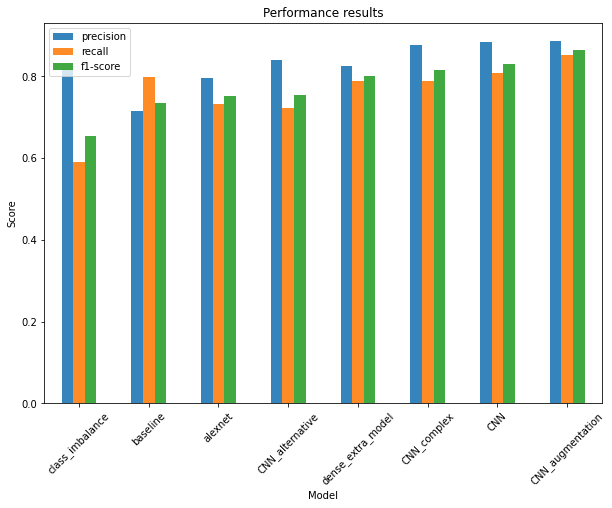

In [ ]:
fig, ax = plt.subplots(figsize = (10, 7))
results.sort_values(by =  "f1-score", ascending = True).plot(ax = ax, kind = "bar", alpha = .9)
ax.set(title = "Performance results",
  xlabel="Model",
  ylabel="Score")
plt.xticks(rotation=45)
plt.draw()

As the plot shows, the top performing model is the CNN with two Convolutional layers and an extra MaxPool layer.

We will draw the baseline confusion matrix and the top performing model one, to compare each other.

In [ ]:
# Build a function to draw the confusion matrix

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, title, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, dpi = 600): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title= title,
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig(f"{title}.png", dpi = dpi)
  

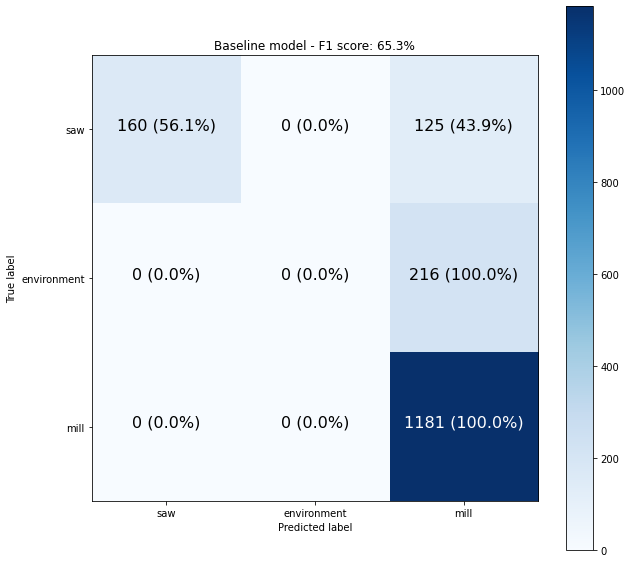

In [ ]:
# Baseline confusion matrix
class_imbalance_title = results_dict["class_imbalance"]["f1-score"]
print()
make_confusion_matrix(
    y_true = y_true,
    y_pred = model_0_preds,
    title = f"Baseline model - F1 score: {class_imbalance_title*100:.1f}%",
    norm = True,
    text_size = 16,
    classes = test_labels,
    savefig = True)

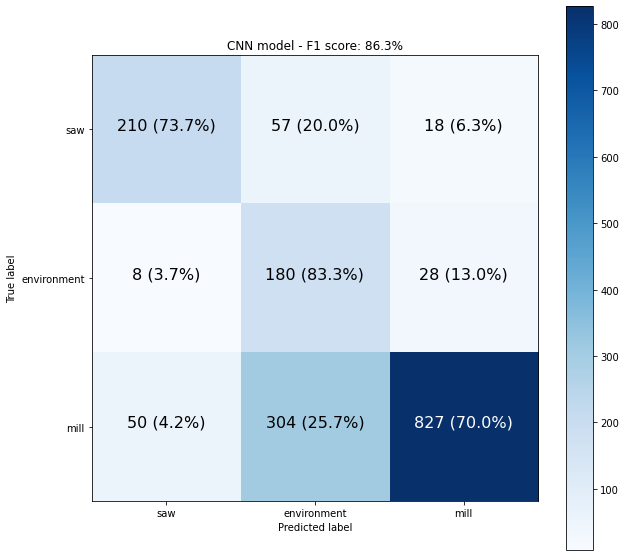

In [ ]:
# Model 5 confusion matrix
cnn_augmented_title = results_dict["CNN_augmentation"]["f1-score"]
make_confusion_matrix(
    y_true = y_true,
    y_pred = model_5_preds,
    title = f"CNN model - F1 score: {cnn_augmented_title*100:.1f}%",
    norm = True,
    text_size = 16,
    classes = test_labels,
    savefig = True)

### Getting the most wrong predictions of model 5

In [ ]:
# Build a dataframe with the most wrong predictions
model_6_insights = {}

model_6_probs_reduced = tf.reduce_max(model_6_probs, axis = 1)  # Get prediction
                                                                # probability
model_6_insights["probs"] = model_6_probs_reduced
model_6_insights["preds"] = model_6_preds  # Predicted class
model_6_insights["y_true"] = y_true  # Ground truth label
model_6_insights["correct"] = (model_6_preds == y_true)

model_6_insights = pd.DataFrame(model_6_insights)
top_10_wrong = model_6_insights.loc[model_6_insights["correct"] == False].sort_values(by = "probs", ascending = False).head(10)

In [ ]:
top_10_wrong_indexes = top_10_wrong.index.values

In [ ]:
# Get validation waveforms from the test files dataset
validation_waveforms_dataset = tf.data.Dataset.from_tensor_slices(test_files)

validation_waveforms = validation_waveforms_dataset.map(
    map_func = get_waveform_and_label,
    num_parallel_calls = tf.data.AUTOTUNE
)
len(validation_waveforms)

1682

In [ ]:
# Map each of the most wrong predictions to its waveform
wrong_waveforms = {}
for i, (waveform, label), in enumerate (validation_waveforms):
  for index in top_10_wrong_indexes:
    if index == i:
      wrong_waveforms[index] = {"waveform" : waveform.numpy(),
                                "label": label.numpy()}

In [ ]:
top_10_wrong_waveforms = pd.DataFrame(wrong_waveforms).transpose()
top_10_wrong_waveforms

waveform    label
76    [0.0051574707, 0.0069885254, -0.044158936, -0....   b'saw'
130   [0.43395996, 0.3527527, 0.24111938, 0.24661255...   b'saw'
270   [-0.02670288, -0.063934326, 0.0071105957, 0.07...   b'saw'
584   [-0.17224121, -0.21255493, 0.021484375, 0.1906...  b'mill'
851   [-0.081970215, -0.14193726, -0.13040161, -0.04...  b'mill'
1044  [-0.03994751, 0.12695312, 0.12548828, 0.041046...  b'mill'
1233  [-0.03286743, -0.05935669, -0.0005493164, 0.03...  b'mill'
1237  [0.119506836, 0.11166382, 0.02557373, -0.06091...  b'mill'
1356  [-0.07473755, -0.2253418, -0.19223022, -0.0649...  b'mill'
1398  [-0.08984375, -0.16229248, -0.033996582, 0.032...  b'mill'

In [ ]:
# Joining the two DataFrames together
top_10_wrong_complete = top_10_wrong.join(top_10_wrong_waveforms).drop(columns = "label", axis = 0)
top_10_wrong_complete

probs  preds  y_true  correct  \
130   0.999993      2       0    False   
76    0.999992      2       0    False   
1398  0.999978      1       2    False   
584   0.999945      1       2    False   
1356  0.999833      1       2    False   
1044  0.999822      1       2    False   
851   0.999723      1       2    False   
270   0.999378      1       0    False   
1237  0.998749      1       2    False   
1233  0.998503      1       2    False   

                                               waveform  
130   [0.43395996, 0.3527527, 0.24111938, 0.24661255...  
76    [0.0051574707, 0.0069885254, -0.044158936, -0....  
1398  [-0.08984375, -0.16229248, -0.033996582, 0.032...  
584   [-0.17224121, -0.21255493, 0.021484375, 0.1906...  
1356  [-0.07473755, -0.2253418, -0.19223022, -0.0649...  
1044  [-0.03994751, 0.12695312, 0.12548828, 0.041046...  
851   [-0.081970215, -0.14193726, -0.13040161, -0.04...  
270   [-0.02670288, -0.063934326, 0.0071105957, 0.07...  
1237  [0.119506836, 0.11166382, 0.02557373, -0.06091...  
1233  [-0.03286743, -0.05935669, -0.0005493164, 0.03...

In [ ]:
# Replacing numerical labels for text version
top_10_wrong_complete["preds"] = top_10_wrong_complete["preds"].apply(lambda x: test_labels[x])
top_10_wrong_complete["y_true"] = top_10_wrong_complete["y_true"].apply(lambda x: test_labels[x])

In [ ]:
top_10_wrong_complete

probs        preds y_true  correct  \
130   0.999993         mill    saw    False   
76    0.999992         mill    saw    False   
1398  0.999978  environment   mill    False   
584   0.999945  environment   mill    False   
1356  0.999833  environment   mill    False   
1044  0.999822  environment   mill    False   
851   0.999723  environment   mill    False   
270   0.999378  environment    saw    False   
1237  0.998749  environment   mill    False   
1233  0.998503  environment   mill    False   

                                               waveform  
130   [0.43395996, 0.3527527, 0.24111938, 0.24661255...  
76    [0.0051574707, 0.0069885254, -0.044158936, -0....  
1398  [-0.08984375, -0.16229248, -0.033996582, 0.032...  
584   [-0.17224121, -0.21255493, 0.021484375, 0.1906...  
1356  [-0.07473755, -0.2253418, -0.19223022, -0.0649...  
1044  [-0.03994751, 0.12695312, 0.12548828, 0.041046...  
851   [-0.081970215, -0.14193726, -0.13040161, -0.04...  
270   [-0.02670288, -0.063934326, 0.0071105957, 0.07...  
1237  [0.119506836, 0.11166382, 0.02557373, -0.06091...  
1233  [-0.03286743, -0.05935669, -0.0005493164, 0.03...

In [ ]:
# Listening at them
for _, probs, pred, y_true_df, _, waveform in top_10_wrong_complete.itertuples():
  print(f"Predicted {pred} at {probs*100:.2f}%, but is {y_true_df}.")
  display.display(display.Audio(tf.squeeze(waveform).numpy(), rate = SAMPLE_RATE))
  print("\n")

Predicted mill at 100.00%, but is saw.




Predicted mill at 100.00%, but is saw.




Predicted environment at 100.00%, but is mill.




Predicted environment at 99.99%, but is mill.




Predicted environment at 99.98%, but is mill.




Predicted environment at 99.98%, but is mill.




Predicted environment at 99.97%, but is mill.




Predicted environment at 99.94%, but is saw.




Predicted environment at 99.87%, but is mill.




Predicted environment at 99.85%, but is mill.


## Downloading saved models


In [ ]:
zip_models = zipfile.ZipFile("models.zip", "w")
for i in range(6):
  zip_models.write(f"/content/model_{i}")
zip_models.close()